In [1]:
import os

import numpy as np
from scipy.stats import sem
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import SR_IS_NHB, SR_NHB
from utils import policy_reval, woodbury, woodbury_SR, decision_policy
from utils_render import plot_nhb_decisions, create_bar_plot, plot_decision_prob

In [2]:
# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [4]:
## Hyperparameters for direct NHB comparison
lambd = 10
alpha = 0.15
alpha_SR = 0.15
beta = 0.6
temp = 1.0
num_steps = 250
num_iterations = 800

In [5]:
def softmax(logits, temp=1.0):
    """softmax function for action selection"""
    exp_logits = np.exp(logits / temp - np.max(logits / temp))
    return exp_logits / np.sum(exp_logits)

# Policy Revaluation

## Run Simulations

### Complete Model

In [6]:
probs_complete = []
num_switch_complete = []
number = 0

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="policy_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=1.0) 
    dec_train = np.random.choice(len(probs), p=probs)

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)

### TD Models

In [7]:
probs_sr, probs_sr_is = [], []
num_switch_sr, num_switch_sr_is = [],[]

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Learn similarly to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)
    

    ##  SR  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)


    ##  SR-IS  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_with_imp.V[1], agent_with_imp.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)

## Action Selection Probs

In [8]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)

# mean_policy_complete = np.mean(num_complete)
# mean_policy_sr = np.mean(num_sr)
# mean_policy_sr_is = np.mean(num_sr_is)

print("Complete: ",np.mean(num_complete), " SR: ", np.mean(num_sr), " SR-IS: ", np.mean(num_sr_is))

Complete:  0.8109375  SR:  0.0  SR-IS:  0.5372023809523809


In [9]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)

mean_policy_complete = np.mean(probs_complete)
mean_policy_sr = np.mean(probs_sr)
mean_policy_sr_is = np.mean(probs_sr_is)

sem_policy_complete = sem(probs_complete)
sem_policy_sr = sem(probs_sr)
sem_policy_sr_is = sem(probs_sr_is)

print("Complete: ", (mean_policy_complete, sem_policy_complete), 
      " SR: ", (mean_policy_sr, sem_policy_sr), 
      " SR-IS: ", (mean_policy_sr_is, sem_policy_sr_is))

Complete:  (0.7936672277398622, 3.92768671851465e-18)  SR:  (5.270425305169915e-06, 4.124137283366436e-07)  SR-IS:  (0.542998902325752, 0.010835539790806892)


# Reward Revaluation

## Run Simulations

### Complete Model

In [10]:
probs_complete = []
num_switch_complete = []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="reward_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=1.0) 
    dec_train = np.random.choice(len(probs), p=probs)


    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)

### TD Models

In [11]:
probs_sr, probs_sr_is = [], []
num_switch_sr, num_switch_sr_is = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Learn similar to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)


    ##  SR  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)
    

    ##  SR-IS  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_with_imp.V[1], agent_with_imp.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)

## Action Selection Probs

In [12]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)

# mean_reward_complete = np.mean(num_complete)
# mean_reward_sr = np.mean(num_sr)
# mean_reward_sr_is = np.mean(num_sr_is)

print(f"Complete: {np.mean(num_complete)} SR: {np.mean(num_sr)} SR-IS: {np.mean(num_sr_is)}")

Complete: 0.8317307692307693 SR: 0.9 SR-IS: 0.7714723926380368


In [13]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)

mean_reward_complete = np.mean(probs_complete)
mean_reward_sr = np.mean(probs_sr)
mean_reward_sr_is = np.mean(probs_sr_is)

sem_reward_complete = sem(probs_complete)
sem_reward_sr = sem(probs_sr)
sem_reward_sr_is = sem(probs_sr_is)

print("Complete: ", (mean_reward_complete, sem_reward_complete), 
      " SR: ", (mean_reward_sr, sem_reward_sr), 
      " SR-IS: ", (mean_reward_sr_is, sem_reward_sr_is))

Complete:  (0.8119087897688396, 0.0)  SR:  (0.9053287767704694, 0.0034497712650673603)  SR-IS:  (0.7659601738243808, 0.0016906454856225252)


# Transition Revaluation

## Run Simulations

### Complete Model

In [14]:
probs_complete = []
num_switch_complete = []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="trans_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=1.0) 
    dec_train = np.random.choice(len(probs), p=probs)

    # Update terminal state values
    T_new = agent_complete.construct_T_new()
    D_new = woodbury(agent=agent_complete, T=T_new, inv=False)
    agent_complete.DR = D_new
    agent_complete.update_Z()
    agent_complete.update_V()
    V_new = agent_complete.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)

In [16]:
agent_complete.T

array([[0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [15]:
T_new

array([[0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

### TD Models

In [15]:
probs_sr, probs_sr_is = [], []
num_switch_sr, num_switch_sr_is = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Learn similar to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)


    ##  SR  ##
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)

    # Transition revaluation
    agent_SR.learn_trans_reval()

    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)


    ##  SR-IS  ##
    probs = softmax(logits=np.array([agent_with_imp.V[1], agent_with_imp.V[2]]), temp=temp)
    dec_train = np.random.choice(len(probs), p=probs)

    # Transition revaluation
    T_new = agent_with_imp.construct_T_new()
    D_new = woodbury(agent=agent_with_imp, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent_with_imp.DR = D_new
    agent_with_imp.update_Z()
    agent_with_imp.update_V()
    V_new = agent_with_imp.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)

## Action Selection Probs

In [16]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)

# mean_transition_complete = np.mean(num_complete)
# mean_transition_sr = np.mean(num_sr)
# mean_transition_sr_is = np.mean(num_sr_is)

print(f"Complete: {np.mean(num_complete)} SR: {np.mean(num_sr)} SR-IS: {np.mean(num_sr_is)}")

Complete: 0.8125 SR: 0.0 SR-IS: 0.5911179173047473


In [17]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)

mean_transition_complete = np.mean(probs_complete)
mean_transition_sr = np.mean(probs_sr)
mean_transition_sr_is = np.mean(probs_sr_is)

sem_transition_complete = sem(probs_complete)
sem_transition_sr = sem(probs_sr)
sem_transition_sr_is = sem(probs_sr_is)

print("Complete: ", (mean_transition_complete, sem_transition_complete), 
      " SR: ", (mean_transition_sr, sem_transition_sr), 
      " SR-IS: ", (mean_transition_sr_is, sem_transition_sr_is))

Complete:  (0.7941296281990529, 3.92768671851465e-18)  SR:  (0.00021319252781285843, 1.3259429108825012e-05)  SR-IS:  (0.5947594736716519, 0.0016787324298186714)


# Plot NHB values against ours

In [18]:
def create_bar_plot(means, colors, ylabel, xlabels, std=None, title=None, save_path=None):
    """
    Bar plot for decision probabilities with minimum visible height for small values

    Args:
        means (array) : mean of each bar to plot
        colors (list) : idx of color palette color to use
        ylabel (string) : label for the y-axis
        xlabels (list of strings) : labels for the x-axis
        std (array, optional) : std error of each bar
        title (string, optional) : title of the plot
        save_path (string, optional) : where to save the figure
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    color_palette = sns.color_palette("colorblind")
    color_list = []
    for color in colors:
        color_list.append(color_palette[color])

    # Set the style and font
    plt.rcParams['font.family'] = 'serif'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(means)) * 0.25
    
    # Create modified means for visualization while preserving original data for error bars
    plot_means = np.array(means).copy()
    min_visible_height = 0.02
    plot_means[plot_means < 0.1] = min_visible_height
    
    # Plot the bars with black edge color
    bars = ax.bar(x, plot_means, color=color_list, edgecolor='black', linewidth=1, width=0.14)
    
    # Add error bars if std is provided, using original means
    if std is not None:
        ax.errorbar(x, means, yerr=std, fmt='none', color='black', capsize=0)
    
    # Customize the plot
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=18) if title else None
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=0, ha='center', fontsize=14)
    
    # Set y-axis limits and ticks
    ax.set_ylim(0, 1.1)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Add black border to all spines
    for spine in ['left', 'right', 'bottom', 'top']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1)
    
    # Remove grid
    ax.grid(False)
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

## NHB reconstruction

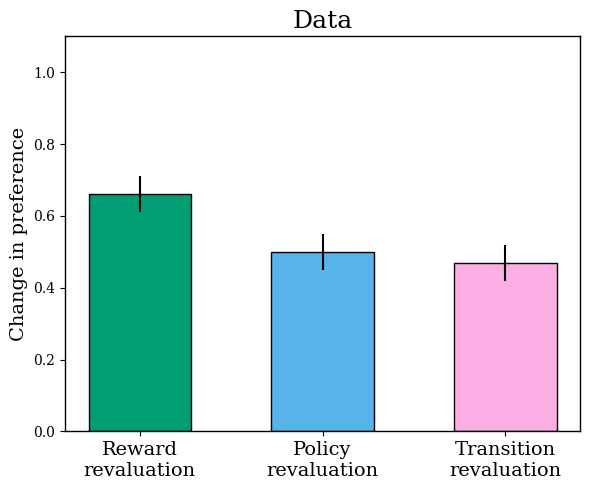

In [19]:
# save_path = save_dir + "NHB_data.png"
save_path = None
nhb_means = [0.66, 0.50, 0.47]
nhb_stds = [0.05, 0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Change in preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data")

## SR-IS

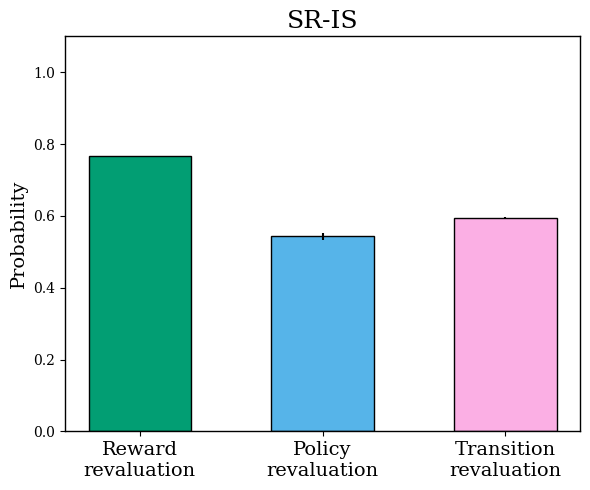

In [20]:
save_path = save_dir + "NHB_with_imp.png"
# save_path = None
means = [mean_reward_sr_is, mean_policy_sr_is, mean_transition_sr_is]
stds = [sem_reward_sr_is, sem_policy_sr_is, sem_transition_sr_is]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR-IS")

## SR

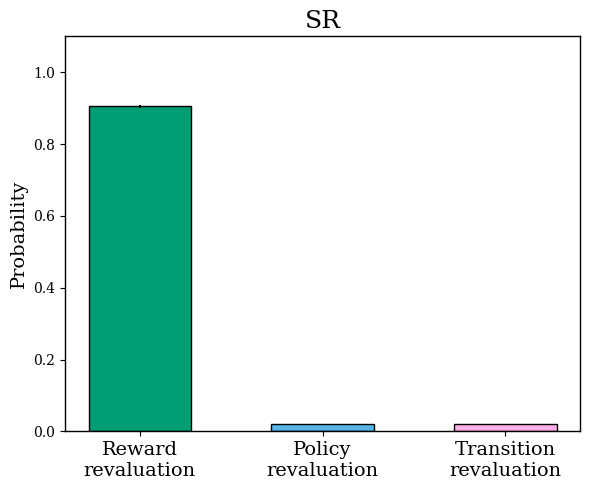

In [21]:
save_path = save_dir + "NHB_SR.png"
# save_path = None
means = [mean_reward_sr, mean_policy_sr, mean_transition_sr]
stds = [sem_reward_sr, sem_policy_sr, sem_transition_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR")

## Complete Model

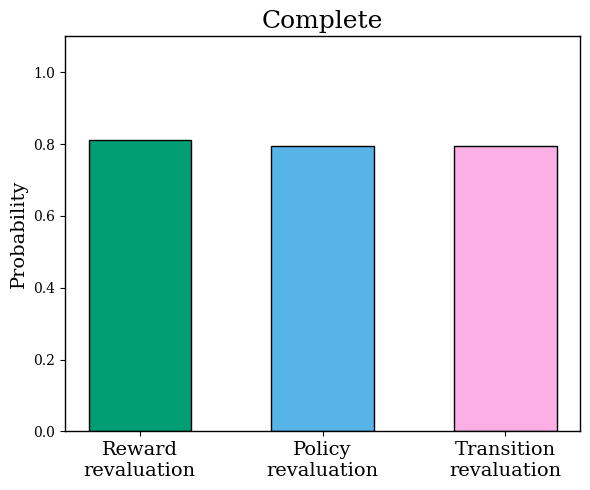

In [22]:
save_path = save_dir + "NHB_Complete.png"
# save_path = None
means = [mean_reward_complete, mean_policy_complete, mean_transition_complete]
stds = [sem_reward_complete, sem_policy_complete, sem_transition_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Complete")